In [1]:
import sys
sys.path.append('../code')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import read_video as rv
import reconstruction_utils as ru

In [102]:
import Reconstruction_pytorch as rec

In [103]:
filepath = 'D:/mCherryCells/Well1_Every1_2/Well1_Every1_2_holo.avi'

In [104]:
data = rv.read_video(filepath, 0, 10)

In [105]:
data.shape

(10, 1450, 1930)

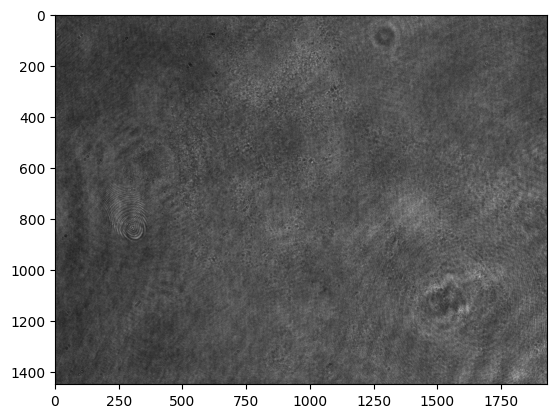

In [106]:
plt.imshow(data[0], cmap='gray')

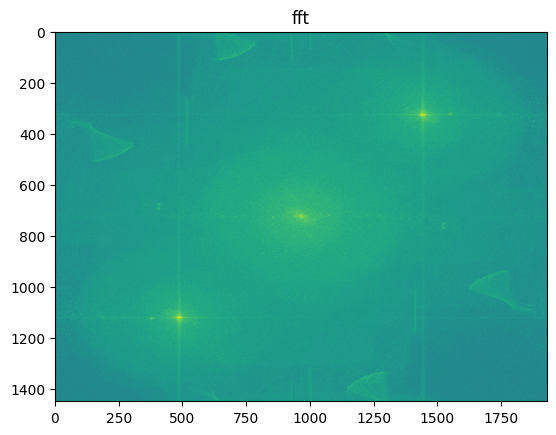

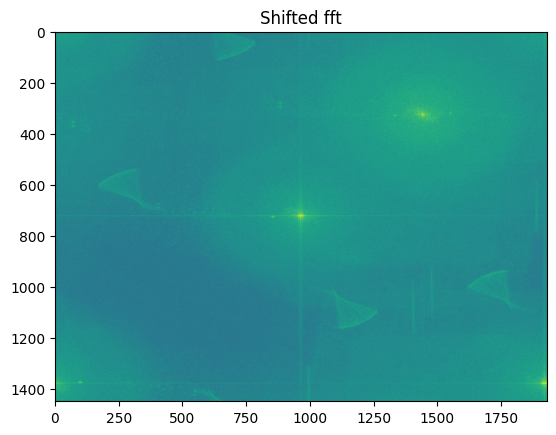

In [108]:
correct_fourier_peak = (0, 0)

frame = data[0]
frame = torch.tensor(frame) - frame.mean()

xr, yr = frame.shape

filter_radius = torch.min(torch.tensor([yr, xr])) / 5

X = torch.arange(frame.shape[0]) - frame.shape[0] // 2
Y = torch.arange(frame.shape[1]) - frame.shape[1] // 2
X, Y = torch.meshgrid(X, Y, indexing='ij')
position_matrix = torch.sqrt((X)**2 + Y**2)

kx = torch.linspace(-torch.pi, torch.pi, xr) 
ky = torch.linspace(-torch.pi, torch.pi, yr)
KX, KY = torch.meshgrid(kx, ky, indexing='ij')

# Initialize FourierPeakFinder
finder = ru.FourierPeakFinder(position_matrix, filter_radius, correct_fourier_peak, KX, KY, X, Y)

# Find peak coordinates in Fourier space
kx_add_ky, dist_peak = finder.find_peak_coordinates(frame)

shifted_fft = torch.fft.fftshift(
    torch.fft.fft2(frame * torch.exp(1j*kx_add_ky))
    )

plt.figure()
plt.title("fft")
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(torch.fft.fft2(frame)))))

plt.figure()
plt.title("Shifted fft")
plt.imshow(torch.log(torch.abs(shifted_fft)))

In [109]:
fftImage = torch.fft.fftshift(torch.fft.fft2(frame))

In [110]:
fftImage = torch.where(position_matrix < filter_radius, torch.tensor(0, dtype=fftImage.dtype, device=fftImage.device), fftImage)
#Set fftImage to zero from 0 to middle of the image
fftImage[:, :yr//2] = 0


fftImage = torch.abs(fftImage)

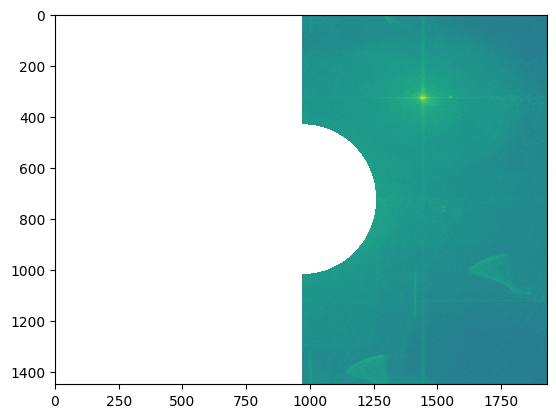

In [111]:
plt.imshow(torch.log(fftImage))

In [112]:
# Compute magnitude of the fftImage
import torch.nn.functional as F
# Apply Gaussian filter to the fftImage
fftImage = F.conv2d(fftImage.real.unsqueeze(0).unsqueeze(0), torch.ones(1, 1, 7, 7, device=fftImage.device) / 49, padding=1).squeeze()

#Find the coordinates of the maximum values in the fftImage
max_index = torch.argmax(fftImage)
max_coords = torch.unravel_index(max_index, fftImage.shape)
max_coords = (max_coords[0], max_coords[1])

In [113]:
max_coords

(tensor(326), tensor(1441))

In [114]:
# Extract coordinates from X and Y matrices
x_pos = position_matrix[max_coords]
y_pos = position_matrix[max_coords]
dist_peak = torch.sqrt(x_pos**2 + y_pos**2)

# Assuming KX and KY are defined similarly to X and Y
kx_pos = KX[max_coords]
ky_pos = KY[max_coords]

# Compute kx_add_ky
kx_add_ky = kx_pos * X + ky_pos * Y

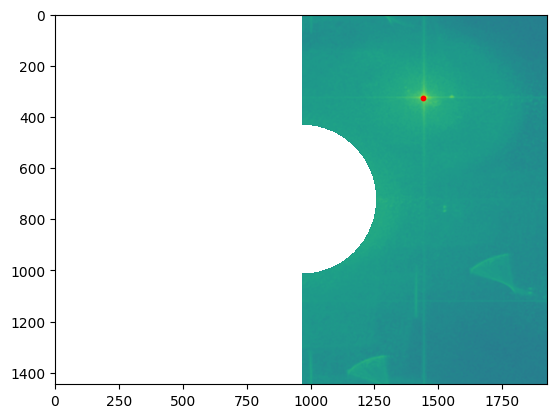

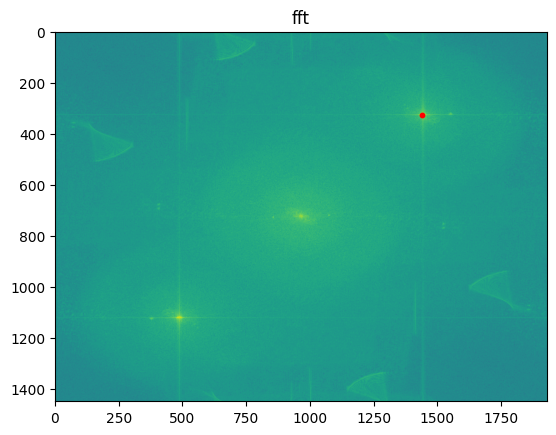

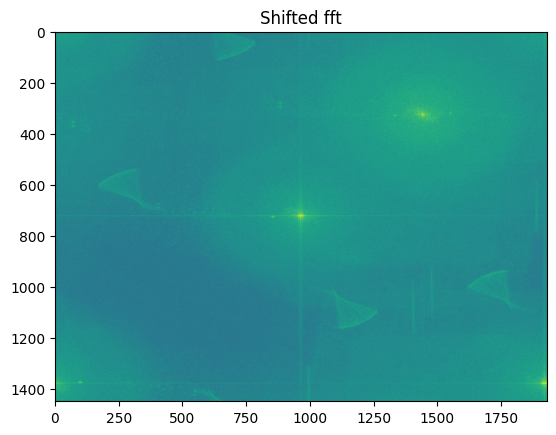

In [115]:
#Visualize where the peak is in the Fourier space

plt.figure()
plt.imshow(torch.log(torch.abs(fftImage)))
plt.scatter(max_coords[1], max_coords[0], color='r', s=10)

#Make so that the peak is in the center of the Fourier space
shifted_fft = torch.fft.fftshift(
    torch.fft.fft2(frame * torch.exp(1j*kx_add_ky))
    )

plt.figure()
plt.title("fft")
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(torch.fft.fft2(frame)))))
plt.scatter(max_coords[1], max_coords[0], color='r', s=10)

plt.figure()
plt.title("Shifted fft")
plt.imshow(torch.log(torch.abs(shifted_fft)))



In [126]:
import other_utils as ou

In [127]:
xr, yr = frame.shape

In [403]:
m = ou.create_ellipse_mask(xr, yr, percent=20/xr)

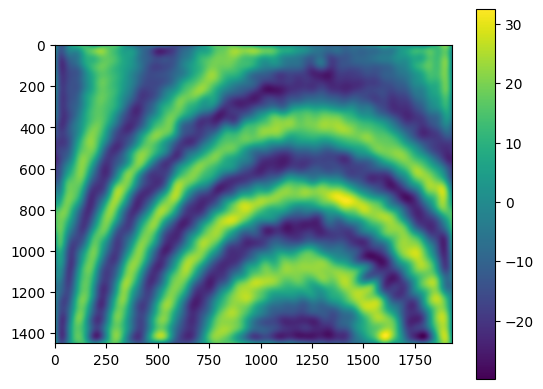

In [404]:
plt.imshow(torch.fft.ifft2(torch.fft.fftshift(shifted_fft*m)).real)
plt.colorbar()

In [376]:
phase_img = torch.angle(torch.fft.ifft2(torch.fft.fftshift(shifted_fft*m)))

In [405]:
import importlib
importlib.reload(rec)
importlib.reload(ru)


<module 'reconstruction_utils' from 'c:\\Users\\Fredrik\\Documents\\GitHub\\HoloRecPytorch\\notebooks\\../code\\reconstruction_utils.py'>

In [387]:
#P2DM = ru.Polynomial2DModel(degree_x=6, degree_y=6, lr= 8e-3)

P2DM = ru.Polynomial2DModelNN()

P2DM.to('cuda')

Polynomial2DModelNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (hidden): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (downsample): Linear(in_features=64, out_features=32, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (output): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [388]:
#Number of parameters
sum([p.numel() for p in P2DM.parameters()])

6465

In [389]:
downsample = 4
x_flat = torch.arange(0, xr, step=downsample)
y_flat = torch.arange(0, yr, step=downsample)

X, Y = torch.meshgrid(x_flat, y_flat, indexing='ij')

X = X.flatten()/1000
Y = Y.flatten()/1000

phase_img_ds = phase_img[::downsample, ::downsample]
Z = phase_img_ds.flatten()

X = X.to('cuda')
Y = Y.to('cuda')
Z = Z.to('cuda')



In [390]:
P2DM.fit(X, Y, Z)

Epoch [1000/100000], Loss: 1.8597
Epoch [2000/100000], Loss: 1.5219
Epoch [3000/100000], Loss: 1.1796
Epoch [4000/100000], Loss: 2.1898
Epoch [5000/100000], Loss: 0.9426
Epoch [6000/100000], Loss: 0.8235
Epoch [7000/100000], Loss: 0.9017
Epoch [8000/100000], Loss: 0.8646
Epoch [9000/100000], Loss: 0.7466
Epoch [10000/100000], Loss: 0.7403
Epoch [11000/100000], Loss: 0.7070
Epoch [12000/100000], Loss: 1.1498
Epoch [13000/100000], Loss: 0.6842
Epoch [14000/100000], Loss: 0.7216
Epoch [15000/100000], Loss: 0.8707
Epoch [16000/100000], Loss: 0.6876
Epoch [17000/100000], Loss: 0.6841
Epoch [18000/100000], Loss: 0.6980
Epoch [19000/100000], Loss: 0.6970
Epoch [20000/100000], Loss: 0.9153
Epoch [21000/100000], Loss: 0.9452
Epoch [22000/100000], Loss: 0.6980
Epoch [23000/100000], Loss: 0.6331
Epoch [24000/100000], Loss: 0.6361
Epoch [25000/100000], Loss: 0.6401
Epoch [26000/100000], Loss: 0.6672
Epoch [27000/100000], Loss: 0.6118
Epoch [28000/100000], Loss: 0.6561
Epoch [29000/100000], Loss: 0

KeyboardInterrupt: 

In [391]:
inp = torch.cat((X.unsqueeze(1), Y.unsqueeze(1)), dim=1)

In [392]:
phase_img_fitted = P2DM(inp).reshape(x_flat.shape[0], y_flat.shape[0])

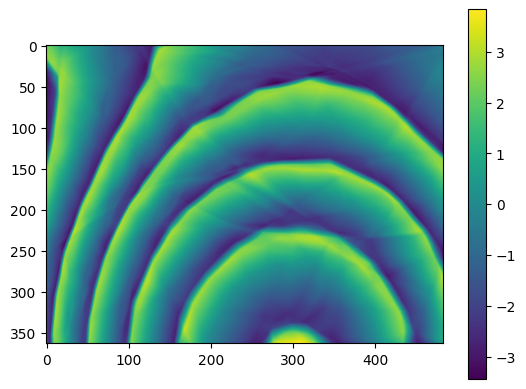

In [393]:
plt.imshow(phase_img_fitted.cpu().detach())
plt.colorbar()

#plt.imshow(phase_img.cpu().detach())
#plt.colorbar()

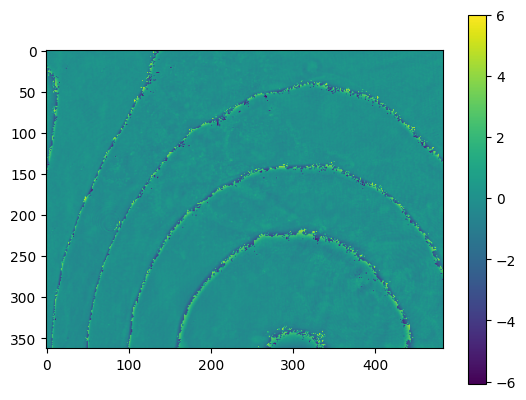

In [394]:
plt.imshow(phase_img[::downsample, ::downsample].cpu().detach() - phase_img_fitted.cpu().detach())
plt.colorbar()

#plt.imshow()
#plt.colorbar()

In [179]:
PF = rec.PolynomialFitterV2(shape=frame.shape)

In [180]:
field = torch.fft.ifft2(torch.fft.fftshift(shifted_fft*m))

In [181]:
field

tensor([[4.0479+3.3325j, 3.1371+3.4208j, 2.2264+3.5120j,  ...,
         6.7587+3.0794j, 5.8611+3.1625j, 4.9567+3.2466j],
        [3.9844+3.3135j, 3.0810+3.4247j, 2.1780+3.5388j,  ...,
         6.6735+2.9915j, 5.7830+3.0975j, 4.8858+3.2046j],
        [3.9149+3.2976j, 3.0190+3.4317j, 2.1236+3.5685j,  ...,
         6.5825+2.9073j, 5.6990+3.0359j, 4.8090+3.1659j],
        ...,
        [4.2018+3.4064j, 3.2684+3.4252j, 2.3349+3.4474j,  ...,
         6.9781+3.3610j, 6.0590+3.3751j, 5.1328+3.3900j],
        [4.1568+3.3792j, 3.2308+3.4212j, 2.3049+3.4664j,  ...,
         6.9112+3.2645j, 5.9993+3.3016j, 5.0804+3.3396j],
        [4.1054+3.3545j, 3.1870+3.4197j, 2.2688+3.4879j,  ...,
         6.8380+3.1705j, 5.9332+3.2306j, 5.0216+3.2917j]])

In [185]:
plt.imshow(torch.angle(field).numpy())
plt.colorbar()

In [175]:
PF2 = rec.PolynomialFitter(shape=frame.shape, order=4, device='cpu')

In [176]:
field.to("cpu")

tensor([[4.0479+3.3325j, 3.1371+3.4208j, 2.2264+3.5120j,  ...,
         6.7587+3.0794j, 5.8611+3.1625j, 4.9567+3.2466j],
        [3.9844+3.3135j, 3.0810+3.4247j, 2.1780+3.5388j,  ...,
         6.6735+2.9915j, 5.7830+3.0975j, 4.8858+3.2046j],
        [3.9149+3.2976j, 3.0190+3.4317j, 2.1236+3.5685j,  ...,
         6.5825+2.9073j, 5.6990+3.0359j, 4.8090+3.1659j],
        ...,
        [4.2018+3.4064j, 3.2684+3.4252j, 2.3349+3.4474j,  ...,
         6.9781+3.3610j, 6.0590+3.3751j, 5.1328+3.3900j],
        [4.1568+3.3792j, 3.2308+3.4212j, 2.3049+3.4664j,  ...,
         6.9112+3.2645j, 5.9993+3.3016j, 5.0804+3.3396j],
        [4.1054+3.3545j, 3.1870+3.4197j, 2.2688+3.4879j,  ...,
         6.8380+3.1705j, 5.9332+3.2306j, 5.0216+3.2917j]])

In [177]:
sub, phase_fit = PF2.fit_and_subtract_phase_background_torch(torch.angle(field))

In [178]:
plt.imshow(phase_fit.cpu().numpy())
plt.colorbar()

In [20]:
aa

NameError: name 'aa' is not defined

In [654]:
import importlib
importlib.reload(rec)
importlib.reload(ru)
importlib.reload(ou)

<module 'other_utils' from 'c:\\Users\\Fredrik\\Documents\\GitHub\\HoloRecPytorch\\notebooks\\../code\\other_utils.py'>

In [655]:
co = rec.HolographicReconstruction()
co.first_image = frame
co.mask_radiis = [200, 20, 5]
co.lowpass_filtered_phase = True
co.crop=100

In [656]:
co.precalculations()

In [657]:
data = torch.tensor(data).to('cuda')

C:\Users\Fredrik\AppData\Local\Temp\ipykernel_30848\3855621883.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to('cuda')


In [658]:
datan = co.forward(data)

Reconstructing 10 holograms.


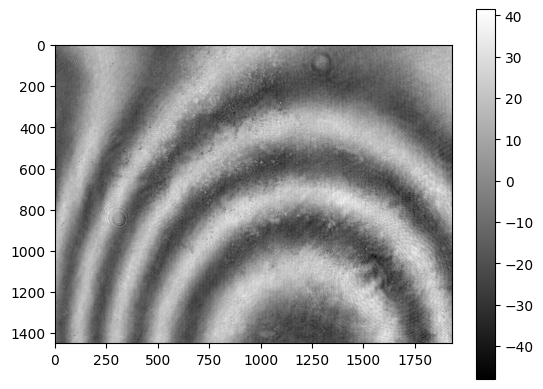

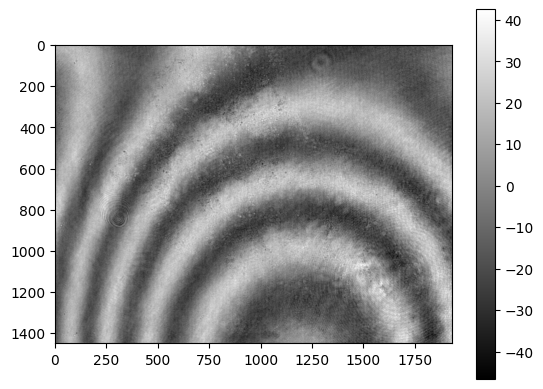

In [659]:
plt.imshow(co.first_field.real.cpu().numpy(), cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(co.first_field_corrected.imag.cpu().numpy(), cmap='gray')
plt.colorbar()

In [660]:
#plt.figure()
#plt.imshow(co.phase_background.real.cpu().numpy(), cmap='gray')
#plt.colorbar()

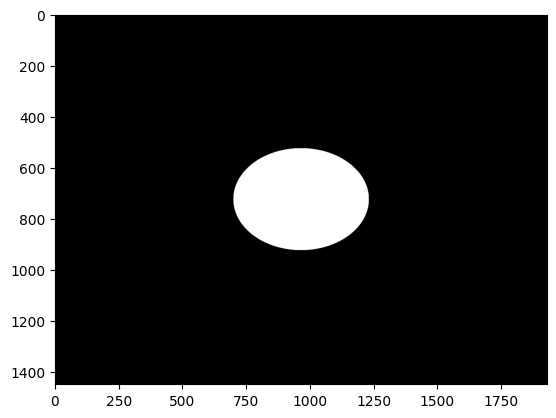

In [661]:
plt.imshow(co.mask_list[0].cpu().numpy(), cmap='gray')

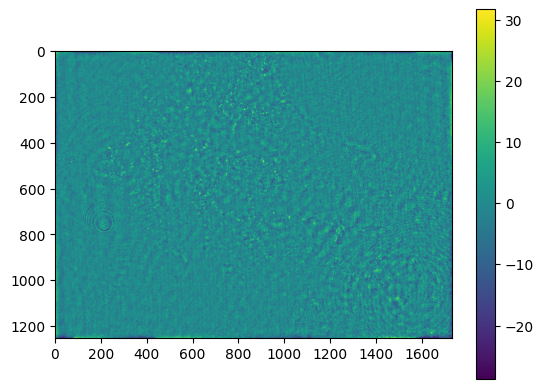

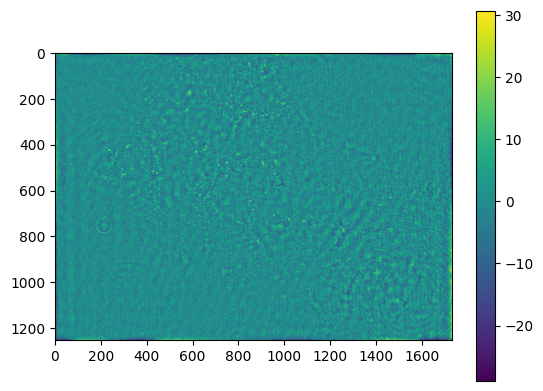

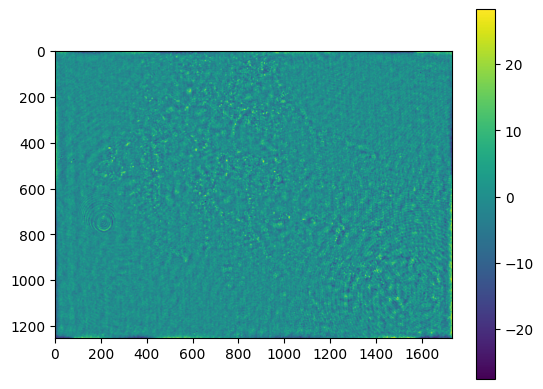

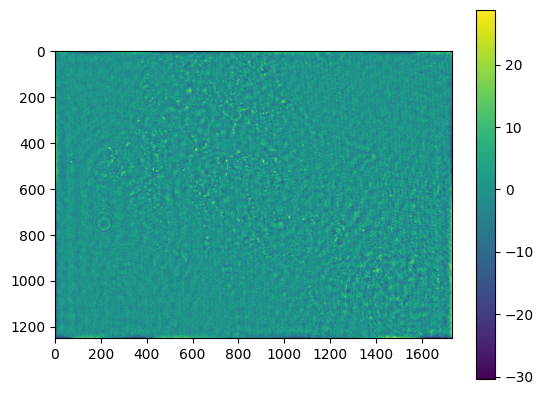

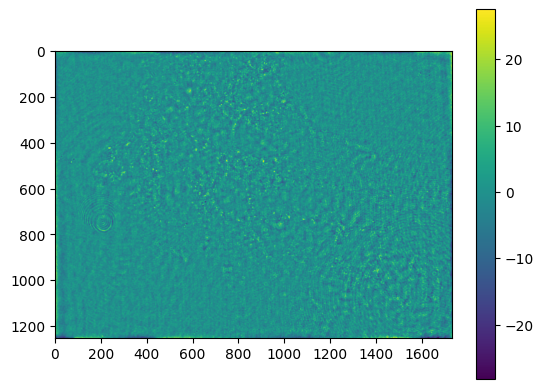

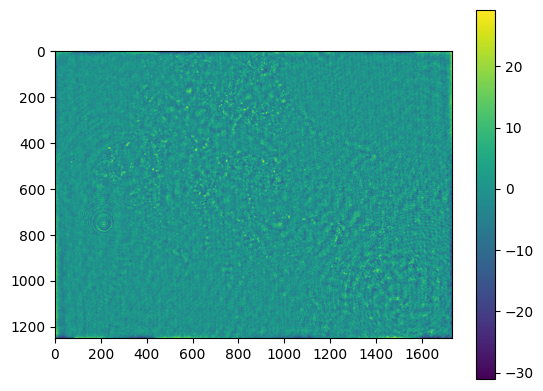

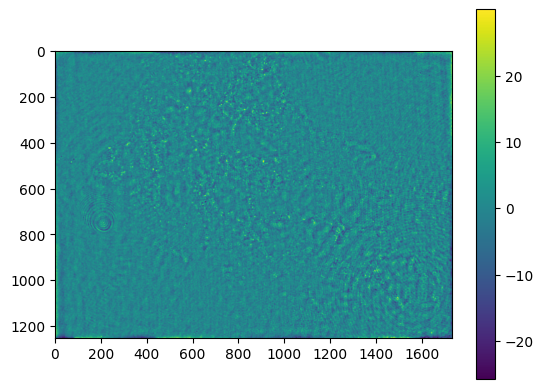

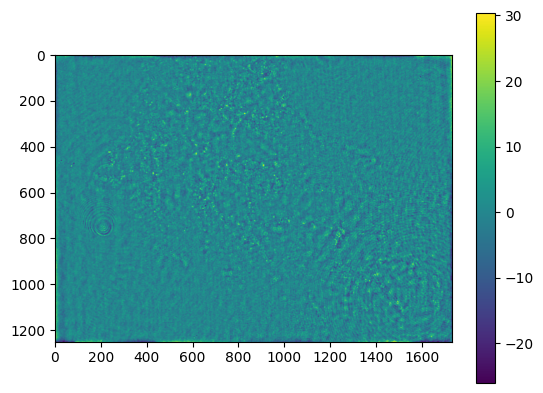

In [662]:
for d in datan:
    plt.figure()
    plt.imshow(d.imag.cpu())
    plt.colorbar()